# Illustrate committor active learning with AMS on the Z potential

In [1]:
from IPython.core.display import  HTML
# Jupyter display settings
display(HTML("<style>.container { width:90% !important; }</style>"))

General imports 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda:0


Imports for AMS and muller brown potential

In [3]:
from potentials.ZPotential import ZPotential
from simulations.AMSSimulation import AMSOverdampedLangevin

Import for committor learning

In [4]:
from committor.neural_net_models import CommittorOneDecoder
from committor.train_committor import TainCommittorOneDecoder

Define potential and neural net for committor approximation and the corresponding training object 

In [5]:
pot = ZPotential()

committor = CommittorOneDecoder([2, 20, 20, 1], [1,20,20, 2], 0, pot)

In [6]:
MEP_1 = [pot.minimum_energy_paths[2][0]]
i = 1
while i < len(pot.minimum_energy_paths[2]):
    if np.sqrt(np.sum((MEP_1[-1] - pot.minimum_energy_paths[2][i])**2)) > pot.dx:
        MEP_1.append(pot.minimum_energy_paths[2][i])
    i += 1
i = 1
while i < len(pot.minimum_energy_paths[0]):
    if np.sqrt(np.sum((MEP_1[-1] - pot.minimum_energy_paths[0][-i])**2)) > pot.dx:
        MEP_1.append(pot.minimum_energy_paths[0][-i])
    i += 1
i = 1
while i < len(pot.minimum_energy_paths[3]):
    if np.sqrt(np.sum((MEP_1[-1] - pot.minimum_energy_paths[3][i])**2)) > pot.dx:
        MEP_1.append(pot.minimum_energy_paths[3][i])
    i += 1
MEP_1 = np.array(MEP_1)

MEP_2 = [pot.minimum_energy_paths[2][0]]
i = 1
while i < len(pot.minimum_energy_paths[2]):
    if np.sqrt(np.sum((MEP_2[-1] - pot.minimum_energy_paths[2][i])**2)) > pot.dx:
        MEP_2.append(pot.minimum_energy_paths[2][i])
    i += 1
i = 1
while i < len(pot.minimum_energy_paths[1]):
    if np.sqrt(np.sum((MEP_2[-1] - pot.minimum_energy_paths[1][-i])**2)) > pot.dx:
        MEP_2.append(pot.minimum_energy_paths[1][-i])
    i += 1
i = 1
while i < len(pot.minimum_energy_paths[3]):
    if np.sqrt(np.sum((MEP_2[-1] - pot.minimum_energy_paths[3][i])**2)) > pot.dx:
        MEP_2.append(pot.minimum_energy_paths[3][i])
    i += 1
MEP_2 = np.array(MEP_2)

Define temperature via $\beta = \left( k_\mathrm{B} T \right)^{-1}$, time step size and AMS simulation object 

In [7]:
beta = 3
dt = 0.05
AMS_on_ZP = AMSOverdampedLangevin(pot, xi=None, beta=beta, forward=True, dt=dt, threshold=10**(-8))

In [8]:
AMS_on_ZP.set_threshold(1.0 * 10**(-2))

Run dynamics to sample intitial conditions in reactant and product metastable state

In [9]:
n_conditions = 10
n_rep = 10
k_min = 1
ini_traj_f, ini_conds_f, _, n_steps_f = AMS_on_ZP.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
AMS_on_ZP.set_forward(False)
ini_traj_b, ini_conds_b, _, n_steps_b = AMS_on_ZP.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
AMS_on_ZP.set_forward(True)
print(n_steps_b + n_steps_f)

1735


In [10]:
N = 400 # time lagg in number of delta t
max_epochs = 10000

boudary_weight = 1.0 * 10**0
dataset = {"single_trajs_pos": [], 
           "single_trajs_gauss": [], 
           "single_trajs_weights": [], 
           'dt': dt, 'beta': beta}

i = 0
while i < len(ini_traj_f["x_traj"]) - N:
    x_traj = []
    gauss_traj = []
    while pot.in_P(ini_traj_f["x_traj"][i]) or pot.in_R(ini_traj_f["x_traj"][i]):
        i += 1
    x_traj.append(ini_traj_f["x_traj"][i:i+1])
    end_in_R_or_P = False
    n = 1
    if i < len(ini_traj_f["x_traj"]) - N:
        while n <= N:
            if not end_in_R_or_P:
                x_traj.append(ini_traj_f["x_traj"][n+i:n+i+1]) 
                gauss_traj.append(ini_traj_f["gauss_traj"][n+i:n+i+1])
            else:
                x_traj.append(x_end)
                gauss_traj.append(np.zeros_like(x_end))
            if pot.in_P(ini_traj_f["x_traj"][n+i]) or pot.in_R(ini_traj_f["x_traj"][n+i]):
                if not end_in_R_or_P:
                    n_max = n
                    x_end = ini_traj_f["x_traj"][n+i:n+i+1]
                end_in_R_or_P = True 
            n += 1
        if end_in_R_or_P:
            i += n_max + 1
        else: 
            i += N + 1
    else:
        i = len(ini_traj_f["x_traj"])
    dataset["single_trajs_pos"].append(x_traj)
    dataset["single_trajs_gauss"].append(gauss_traj)
    if end_in_R_or_P:
        dataset["single_trajs_weights"].append([boudary_weight])
    else:
        dataset["single_trajs_weights"].append([1.])
i = 0
while i < len(ini_traj_b["x_traj"]) - N:
    x_traj = []
    gauss_traj = []
    while pot.in_P(ini_traj_b["x_traj"][i]) or pot.in_R(ini_traj_b["x_traj"][i]):
        i += 1
    x_traj.append(ini_traj_b["x_traj"][i:i+1])
    end_in_R_or_P = False
    n = 1
    if i < len(ini_traj_b["x_traj"]) - N:
        while n <= N:
            if not end_in_R_or_P:
                x_traj.append(ini_traj_b["x_traj"][n+i:n+i+1]) 
                gauss_traj.append(ini_traj_b["gauss_traj"][n+i:n+i+1])
            else:
                x_traj.append(x_end)
                gauss_traj.append(np.zeros_like(x_end))
            if pot.in_P(ini_traj_b["x_traj"][n+i]) or pot.in_R(ini_traj_b["x_traj"][n+i]):
                if not end_in_R_or_P:
                    n_max = n
                    x_end = ini_traj_b["x_traj"][n+i:n+i+1]
                end_in_R_or_P = True 
            n += 1
        if end_in_R_or_P:
            i += n_max + 1
        else: 
            i += N + 1
    else:
        i = len(ini_traj_f["x_traj"])
    dataset["single_trajs_pos"].append(x_traj)
    dataset["single_trajs_gauss"].append(gauss_traj)
    if end_in_R_or_P:
        dataset["single_trajs_weights"].append([boudary_weight])
    else:
        dataset["single_trajs_weights"].append([1.])
dataset["single_trajs_weights"] = np.array(dataset["single_trajs_weights"])
dataset["single_trajs_gauss"] = np.array(dataset["single_trajs_gauss"])[:, :, 0, :]
dataset["single_trajs_pos"] = np.array(dataset["single_trajs_pos"])[:, :, 0, :]

In [11]:
dataset["single_trajs_gauss"].shape

(25, 400, 2)

   Define the committor training object, and prepare training

In [12]:
committor_training = TainCommittorOneDecoder(committor, pot, dataset)
committor_training.train_test_split(train_size= 2 * 10**1)
committor_training.split_training_dataset_K_folds(2)
committor_training.set_train_val_data(0)
committor_training.set_optimizer('Adam', 0.001)
loss_params = {}
loss_params["ito_loss_weight"] = 1.0
loss_params["pen_points_weight"] = 0.0 * 10**0
loss_params["n_wait"] = 50

committor_training.set_loss_weight(loss_params)
batch_size = 10**1
max_epochs = 100

log_ito_loss_weight value not provided, set to default value of:  0.0
strahan_loss_weight value not provided, set to default value of:  0.0
boltz_traj_fixed_point_loss_weight_1 value not provided, set to default value of:  0.0
boltz_traj_fixed_point_loss_weight_2 value not provided, set to default value of:  0.0
multiple_trajs_fixed_point_loss_weight_1 value not provided, set to default value of:  0.0
multiple_trajs_fixed_point_loss_weight_2 value not provided, set to default value of:  0.0
squared_grad_boltz_weight value not provided, set to default value of:  0.0
mse_boltz_weight value not provided, set to default value of:  0.0
mse_react_weight value not provided, set to default value of:  0.0
l1_pen_weight value not provided, set to default value of:  0
l2_pen_weight value not provided, set to default value of:  0


Train the committor model 

In [13]:
loss_dict = committor_training.train(batch_size, max_epochs)

training ends after 100 epochs.



Plot results

/tmp/ipykernel_50793/3410292235.py:11: RuntimeWarning: divide by zero encountered in log
  contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
/tmp/ipykernel_50793/3410292235.py:25: RuntimeWarning: divide by zero encountered in log
  contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1-xi_on_grid), 40, cmap='viridis')


Text(0.5, 1.0, 'log(1 - committor) iso-levels')

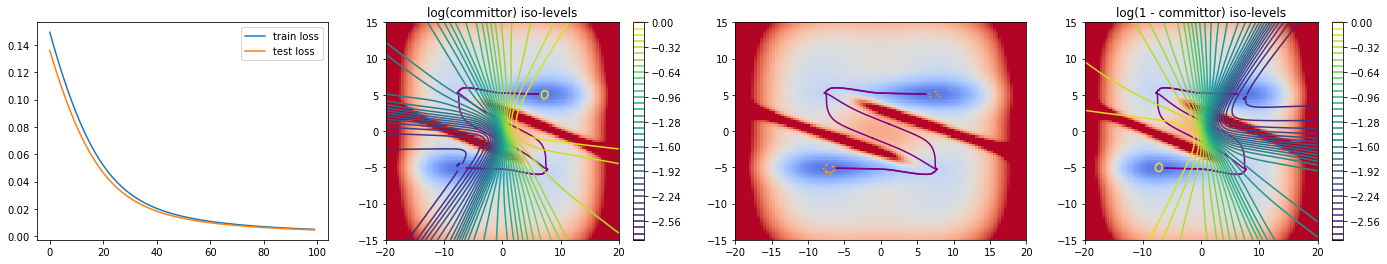

In [14]:
xi_on_grid = committor_training.committor_model.xi_forward(pot.x2d).reshape([100, 100])
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(24, 4)) 
# loss function evolution 
ax0.plot(loss_dict["train_loss"][:], label='train loss')
ax0.plot(loss_dict["test_loss"][:], label='test loss')
ax0.legend()
# log committor plot 
pot.plot_potential_heat_map(ax1)
ax1.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax1.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour1, ax=ax1) 
ax1.set_title("log(committor) iso-levels")
# dataset distribution 
pot.plot_potential_heat_map(ax2)
ax2.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax2.plot(MEP_2[:,0], MEP_2[:,1], color='purple')

ax2.scatter(committor_training.dataset["single_trajs_pos"][:,0, 0], committor_training.dataset["single_trajs_pos"][:,0,1], color='orange', s=0.5)
# log 1- committor plot  
pot.plot_potential_heat_map(ax3)
ax3.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax3.plot(MEP_2[:,0], MEP_2[:,1], color='purple')

contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1-xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour3, ax=ax3) 
ax3.set_title("log(1 - committor) iso-levels")

Run AMS forward

In [15]:
AMS_on_ZP.set_threshold(1.0 * 10**(-2))
AMS_on_ZP.set_xi(committor_training.committor_model.xi_forward)
p_f, z_kills_f, replicas_f, total_md_steps_f = AMS_on_ZP.ams_run(ini_conds_f, n_rep, k_min, return_all=True, save_gauss=True)
AMS_on_ZP.set_forward(False)
AMS_on_ZP.set_xi(committor_training.committor_model.xi_backward)
p_b, z_kills_b, replicas_b, total_md_steps_b = AMS_on_ZP.ams_run(ini_conds_b, n_rep, k_min, return_all=True, save_gauss=True)
AMS_on_ZP.set_forward(True)

In [16]:
print(p_f)
print(p_b)

5.984132507226398e-11
0.0


Add the new sampled trajectories to the dataset

In [17]:
N = 400 # time lagg in number of delta t
max_epochs = 10000

boudary_weight = 1.0 * 10**0
dset = {"single_trajs_pos": [], 
        "single_trajs_gauss": [], 
        "single_trajs_weights": []}
for j in range(0, len(replicas_f)):
    i = 0
    while i < len(replicas_f[j]["x_traj"]) - N:
        x_traj = []
        gauss_traj = []
        while pot.in_P(replicas_f[j]["x_traj"][i]) or pot.in_R(replicas_f[j]["x_traj"][i]):
            i += 1
        x_traj.append(replicas_f[j]["x_traj"][i:i+1])
        end_in_R_or_P = False
        n = 1
        if i < len(replicas_f[j]["x_traj"]) - N:
            while n <= N:
                if not end_in_R_or_P:
                    x_traj.append(replicas_f[j]["x_traj"][n+i:n+i+1]) 
                    gauss_traj.append(replicas_f[j]["gauss_traj"][n+i:n+i+1])
                else:
                    x_traj.append(x_end)
                    gauss_traj.append(np.zeros_like(x_end))
                if pot.in_P(replicas_f[j]["x_traj"][n+i]) or pot.in_R(replicas_f[j]["x_traj"][n+i]):
                    if not end_in_R_or_P:
                        n_max = n
                        x_end = replicas_f[j]["x_traj"][n+i:n+i+1]
                    end_in_R_or_P = True 
                n += 1
            if end_in_R_or_P:
                i += n_max + 1
            else: 
                i += N + 1
        else:
            i = len(replicas_f[j]["x_traj"])
        dset["single_trajs_pos"].append(x_traj)
        dset["single_trajs_gauss"].append(gauss_traj)
        if end_in_R_or_P:
            dset["single_trajs_weights"].append([boudary_weight])
        else:
            dset["single_trajs_weights"].append([1.])
for j in range(0, len(replicas_b)):
    i = 0
    while i < len(replicas_b[j]["x_traj"]) - N:
        x_traj = []
        gauss_traj = []
        while pot.in_P(replicas_b[j]["x_traj"][i]) or pot.in_R(replicas_b[j]["x_traj"][i]):
            i += 1
        x_traj.append(replicas_b[j]["x_traj"][i:i+1])
        end_in_R_or_P = False
        n = 1
        if i < len(replicas_b[j]["x_traj"]) - N:
            while n <= N:
                if not end_in_R_or_P:
                    x_traj.append(replicas_b[j]["x_traj"][n+i:n+i+1]) 
                    gauss_traj.append(replicas_b[j]["gauss_traj"][n+i:n+i+1])
                else:
                    x_traj.append(x_end)
                    gauss_traj.append(np.zeros_like(x_end))
                if pot.in_P(replicas_b[j]["x_traj"][n+i]) or pot.in_R(replicas_b[j]["x_traj"][n+i]):
                    if not end_in_R_or_P:
                        n_max = n
                        x_end = replicas_b[j]["x_traj"][n+i:n+i+1]
                    end_in_R_or_P = True 
                n += 1
            if end_in_R_or_P:
                i += n_max + 1
            else: 
                i += N + 1
        else:
            i = len(replicas_b[j]["x_traj"])
        dset["single_trajs_pos"].append(x_traj)
        dset["single_trajs_gauss"].append(gauss_traj)
        if end_in_R_or_P:
            dset["single_trajs_weights"].append([boudary_weight])
        else:
            dset["single_trajs_weights"].append([1.])

In [18]:
dataset["single_trajs_weights"] = np.append(dataset["single_trajs_weights"], np.array(dset["single_trajs_weights"]), axis=0)
dataset["single_trajs_gauss"] = np.append(dataset["single_trajs_gauss"], np.array(dset["single_trajs_gauss"])[:, :, 0, :], axis=0)
dataset["single_trajs_pos"] = np.append(dataset["single_trajs_pos"], np.array(dset["single_trajs_pos"])[:, :, 0, :], axis=0)

In [19]:
dataset["single_trajs_pos"].shape

(2588, 401, 2)

Re-set the training dataset and train again 

In [20]:
committor_training.set_dataset(dataset)
committor_training.train_test_split(train_size= 25 * 10**2)
committor_training.split_training_dataset_K_folds(2)
committor_training.set_train_val_data(0)
committor_training.set_optimizer('Adam', 0.001)
batch_size = 10**2
max_epochs = 10000
loss_dict = committor_training.train(batch_size, max_epochs)

training ends after 667 epochs.



Plot the results 

/tmp/ipykernel_50793/4094557544.py:12: RuntimeWarning: divide by zero encountered in log
  contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
/tmp/ipykernel_50793/4094557544.py:26: RuntimeWarning: divide by zero encountered in log
  contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1 - xi_on_grid), 40, cmap='viridis')


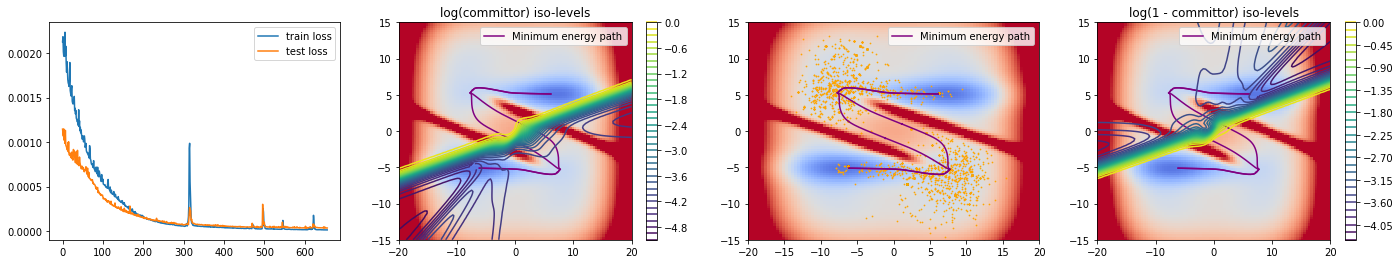

In [21]:
xi_on_grid = committor_training.committor_model.xi_forward(pot.x2d).reshape([100, 100])
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(24, 4)) 
# loss function evolution 
ax0.plot(loss_dict["train_loss"][10:], label='train loss')
ax0.plot(loss_dict["test_loss"][10:], label='test loss')
ax0.legend()
# log committor plot 
pot.plot_potential_heat_map(ax1)
ax1.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax1.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax1.legend()
contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour1, ax=ax1) 
ax1.set_title("log(committor) iso-levels")
# dataset distribution 
pot.plot_potential_heat_map(ax2)
ax2.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax2.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax2.scatter(committor_training.dataset["single_trajs_pos"][:,0, 0], committor_training.dataset["single_trajs_pos"][:,0,1], color='orange', s=0.5)
ax2.legend()

# log 1- committor plot  
pot.plot_potential_heat_map(ax3)
ax3.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax3.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1 - xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour3, ax=ax3) 
ax3.set_title("log(1 - committor) iso-levels")
ax3.legend()

Test the quality with the reference from finite elements method.

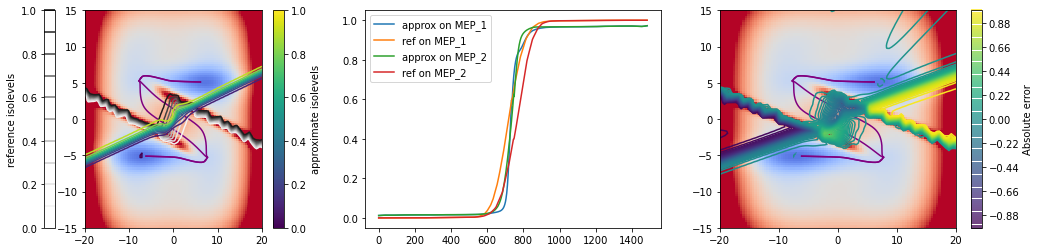

In [22]:
pts = np.loadtxt('ZP_pts.csv', delimiter=',', dtype=float)
tri = np.loadtxt('ZP_tri.csv', delimiter=',', dtype=int)
q = np.loadtxt('ZP_comm.txt', dtype=float)
from matplotlib.tri import Triangulation, TriFinder, LinearTriInterpolator
triangulation = Triangulation(pts[:,0], pts[:,1], tri)
interp = LinearTriInterpolator(triangulation, q, trifinder=triangulation.get_trifinder())

ref_committor_x2d = interp._interpolate_multikeys(x=pot.x2d[:,0], y=pot.x2d[:,1], tri_index=None, return_keys=('z',))[0].data.reshape(pot.n_bins_x, pot.n_bins_y)
committor_on_x2d = committor_training.committor_model.xi_forward(pot.x2d).reshape(pot.n_bins_x, pot.n_bins_y)

fig, (ax1, ax0, ax2) = plt.subplots(1, 3, figsize=(18, 4)) 
pot.plot_potential_heat_map(ax1)
ax1.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax1.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, ref_committor_x2d, np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]), cmap='Greys')
contour2 = committor_training.plot_committor_iso_levels(ax1, np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]), set_lim=False)
fig.colorbar(contour1, ax=ax1, label="reference isolevels", location="left") 
fig.colorbar(contour2, ax=ax1, label="approximate isolevels", location="right") 

pot.plot_potential_heat_map(ax2)
ax2.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax2.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
contour = ax2.contour(pot.x_plot, pot.y_plot, ref_committor_x2d - committor_on_x2d, 100, cmap='viridis')
fig.colorbar(contour, ax=ax2, label="Absolute error") 

ref_committor_MEP1 = interp._interpolate_multikeys(x=MEP_1[:, 0], y=MEP_1[:, 1], tri_index=None, return_keys=('z',))[0]
ref_committor_MEP2 = interp._interpolate_multikeys(x=MEP_2[:, 0], y=MEP_2[:, 1], tri_index=None, return_keys=('z',))[0]
committor_on_MEP1 = committor_training.committor_model.xi_forward(MEP_1)
committor_on_MEP2 = committor_training.committor_model.xi_forward(MEP_2)


ax0.plot(committor_on_MEP1, label="approx on MEP_1")
ax0.plot(ref_committor_MEP1, label="ref on MEP_1")
ax0.plot(committor_on_MEP2, label="approx on MEP_2")
ax0.plot(ref_committor_MEP2, label="ref on MEP_2")
#ax0.plot(err_MEP, label="error on MEP2")
ax0.legend()

In [23]:
# Compute RMSE on a sample of 1000 configurations distributed according ot the reactive trajectories measure. 
react = np.loadtxt('react_trajs_ZP.txt')

ref_committor_react = interp._interpolate_multikeys(x=react[:,0], y=react[:,1], tri_index=None, return_keys=('z',))[0]
app_committor_react = committor_training.committor_model.xi_forward(react)[:, 0]
RMSE = np.sqrt(np.mean((ref_committor_react - app_committor_react)**2))
print("RMSE react = ", RMSE)

RMSE react =  0.03254460803290303


## New iteration of the learning procedure. 

store the old values of the approximate committor 

In [67]:
app_committor_react_old = app_committor_react.copy()

Sample some new initial conditions 

In [68]:
n_conditions = 10
n_rep = 10
k_min = 1
ini_traj_f, ini_conds_f, _, n_steps_f = AMS_on_ZP.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
AMS_on_ZP.set_forward(False)
ini_traj_b, ini_conds_b, _, n_steps_b = AMS_on_ZP.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
AMS_on_ZP.set_forward(True)
print(n_steps_b + n_steps_f)

2631


Add to the dataset

In [69]:
N = 400 # time lagg in number of delta t
max_epochs = 10000

boudary_weight = 1.0 * 10**0
dset = {"single_trajs_pos": [], 
        "single_trajs_gauss": [], 
        "single_trajs_weights": []}

i = 0
while i < len(ini_traj_f["x_traj"]) - N:
    x_traj = []
    gauss_traj = []
    while pot.in_P(ini_traj_f["x_traj"][i]) or pot.in_R(ini_traj_f["x_traj"][i]):
        i += 1
    x_traj.append(ini_traj_f["x_traj"][i:i+1])
    end_in_R_or_P = False
    n = 1
    if i < len(ini_traj_f["x_traj"]) - N:
        while n <= N:
            if not end_in_R_or_P:
                x_traj.append(ini_traj_f["x_traj"][n+i:n+i+1]) 
                gauss_traj.append(ini_traj_f["gauss_traj"][n+i:n+i+1])
            else:
                x_traj.append(x_end)
                gauss_traj.append(np.zeros_like(x_end))
            if pot.in_P(ini_traj_f["x_traj"][n+i]) or pot.in_R(ini_traj_f["x_traj"][n+i]):
                if not end_in_R_or_P:
                    n_max = n
                    x_end = ini_traj_f["x_traj"][n+i:n+i+1]
                end_in_R_or_P = True 
            n += 1
        if end_in_R_or_P:
            i += n_max + 1
        else: 
            i += N + 1
    else:
        i = len(ini_traj_f["x_traj"])
    dset["single_trajs_pos"].append(x_traj)
    dset["single_trajs_gauss"].append(gauss_traj)
    if end_in_R_or_P:
        dset["single_trajs_weights"].append([boudary_weight])
    else:
        dset["single_trajs_weights"].append([1.])
i = 0
while i < len(ini_traj_b["x_traj"]) - N:
    x_traj = []
    gauss_traj = []
    while pot.in_P(ini_traj_b["x_traj"][i]) or pot.in_R(ini_traj_b["x_traj"][i]):
        i += 1
    x_traj.append(ini_traj_b["x_traj"][i:i+1])
    end_in_R_or_P = False
    n = 1
    if i < len(ini_traj_b["x_traj"]) - N:
        while n <= N:
            if not end_in_R_or_P:
                x_traj.append(ini_traj_b["x_traj"][n+i:n+i+1]) 
                gauss_traj.append(ini_traj_b["gauss_traj"][n+i:n+i+1])
            else:
                x_traj.append(x_end)
                gauss_traj.append(np.zeros_like(x_end))
            if pot.in_P(ini_traj_b["x_traj"][n+i]) or pot.in_R(ini_traj_b["x_traj"][n+i]):
                if not end_in_R_or_P:
                    n_max = n
                    x_end = ini_traj_b["x_traj"][n+i:n+i+1]
                end_in_R_or_P = True 
            n += 1
        if end_in_R_or_P:
            i += n_max + 1
        else: 
            i += N + 1
    else:
        i = len(ini_traj_f["x_traj"])
    dset["single_trajs_pos"].append(x_traj)
    dset["single_trajs_gauss"].append(gauss_traj)
    if end_in_R_or_P:
        dset["single_trajs_weights"].append([boudary_weight])
    else:
        dset["single_trajs_weights"].append([1.])

In [70]:
dataset["single_trajs_weights"] = np.append(dataset["single_trajs_weights"], np.array(dset["single_trajs_weights"]), axis=0)
dataset["single_trajs_gauss"] = np.append(dataset["single_trajs_gauss"], np.array(dset["single_trajs_gauss"])[:, :, 0, :], axis=0)
dataset["single_trajs_pos"] = np.append(dataset["single_trajs_pos"], np.array(dset["single_trajs_pos"])[:, :, 0, :], axis=0)

In [71]:
#dataset["single_trajs_weights"] = dataset["single_trajs_weights"][:46364]

In [72]:
dataset["single_trajs_gauss"].shape

(5739, 400, 2)

Run AMS again 

In [73]:
epsilon = 10**(-20)
def log_comm_forward_xi(X):
    return np.log(committor_training.committor_model.xi_forward(X) + epsilon)

def log_comm_backward_xi(X):
    return np.log(committor_training.committor_model.xi_backward(X) + epsilon)

In [74]:
AMS_on_ZP.set_threshold(1.0 * 10**(-2))
AMS_on_ZP.set_xi(committor_training.committor_model.xi_forward)
#AMS_on_ZP.set_xi(log_comm_forward_xi)
p_f, z_kills_f, replicas_f, total_md_steps_f = AMS_on_ZP.ams_run(ini_conds_f, n_rep, k_min, return_all=True, save_gauss=True)
AMS_on_ZP.set_forward(False)
AMS_on_ZP.set_xi(committor_training.committor_model.xi_backward)
#AMS_on_ZP.set_xi(log_comm_backward_xi)
p_b, z_kills_b, replicas_b, total_md_steps_b = AMS_on_ZP.ams_run(ini_conds_b, n_rep, k_min, return_all=True, save_gauss=True)
AMS_on_ZP.set_forward(True)

In [75]:
z_kills_f

[array([[0.35499394]], dtype=float32),
 array([[0.3652735]], dtype=float32),
 array([[0.36567307]], dtype=float32),
 array([[0.36668184]], dtype=float32),
 array([[0.3772651]], dtype=float32),
 array([[0.37733233]], dtype=float32),
 array([[0.37804547]], dtype=float32),
 array([[0.3809776]], dtype=float32),
 array([[0.381541]], dtype=float32),
 array([[0.38363636]], dtype=float32),
 array([[0.38486484]], dtype=float32),
 array([[0.3850832]], dtype=float32),
 array([[0.38684428]], dtype=float32),
 array([[0.38873336]], dtype=float32),
 array([[0.39191422]], dtype=float32),
 array([[0.39250636]], dtype=float32),
 array([[0.3933423]], dtype=float32),
 array([[0.39418796]], dtype=float32),
 array([[0.39898878]], dtype=float32),
 array([[0.40157825]], dtype=float32),
 array([[0.4018219]], dtype=float32),
 array([[0.40201604]], dtype=float32),
 array([[0.40427643]], dtype=float32),
 array([[0.408165]], dtype=float32),
 array([[0.40818173]], dtype=float32),
 array([[0.4200065]], dtype=float32

In [76]:
z_kills_b

[array([[0.23798227]], dtype=float32),
 array([[0.24829072]], dtype=float32),
 array([[0.25970948]], dtype=float32),
 array([[0.26317334]], dtype=float32),
 array([[0.26472962]], dtype=float32),
 array([[0.26705343]], dtype=float32),
 array([[0.26904404]], dtype=float32),
 array([[0.27382207]], dtype=float32),
 array([[0.28302538]], dtype=float32),
 array([[0.2838021]], dtype=float32),
 array([[0.28459138]], dtype=float32),
 array([[0.28557414]], dtype=float32),
 array([[0.28977674]], dtype=float32),
 array([[0.29252797]], dtype=float32),
 array([[0.30336887]], dtype=float32),
 array([[0.31702536]], dtype=float32),
 array([[0.32909626]], dtype=float32),
 array([[0.34040093]], dtype=float32),
 array([[0.35390884]], dtype=float32),
 array([[0.3679453]], dtype=float32),
 array([[0.3795691]], dtype=float32),
 array([[0.39289385]], dtype=float32),
 array([[0.3932733]], dtype=float32),
 array([[0.40665805]], dtype=float32),
 array([[0.41764593]], dtype=float32),
 array([[0.43388057]], dtype=

In [77]:
print(p_f)
print(p_b)

0.0
0.0


Add sampled trajectories data to dataset 

In [57]:
N = 400 # time lagg in number of delta t
max_epochs = 10000

boudary_weight = 1.0 * 10**0
dset = {"single_trajs_pos": [], 
        "single_trajs_gauss": [], 
        "single_trajs_weights": []}
for j in range(0, len(replicas_f)):
    i = 0
    while i < len(replicas_f[j]["x_traj"]) - N:
        x_traj = []
        gauss_traj = []
        while pot.in_P(replicas_f[j]["x_traj"][i]) or pot.in_R(replicas_f[j]["x_traj"][i]):
            i += 1
        x_traj.append(replicas_f[j]["x_traj"][i:i+1])
        end_in_R_or_P = False
        n = 1
        if i < len(replicas_f[j]["x_traj"]) - N:
            while n <= N:
                if not end_in_R_or_P:
                    x_traj.append(replicas_f[j]["x_traj"][n+i:n+i+1]) 
                    gauss_traj.append(replicas_f[j]["gauss_traj"][n+i:n+i+1])
                else:
                    x_traj.append(x_end)
                    gauss_traj.append(np.zeros_like(x_end))
                if pot.in_P(replicas_f[j]["x_traj"][n+i]) or pot.in_R(replicas_f[j]["x_traj"][n+i]):
                    if not end_in_R_or_P:
                        n_max = n
                        x_end = replicas_f[j]["x_traj"][n+i:n+i+1]
                    end_in_R_or_P = True 
                n += 1
            if end_in_R_or_P:
                i += n_max + 1
            else: 
                i += N + 1
        else:
            i = len(replicas_f[j]["x_traj"])
        dset["single_trajs_pos"].append(x_traj)
        dset["single_trajs_gauss"].append(gauss_traj)
        if end_in_R_or_P:
            dset["single_trajs_weights"].append([boudary_weight])
        else:
            dset["single_trajs_weights"].append([1.])
for j in range(0, len(replicas_b)):
    i = 0
    while i < len(replicas_b[j]["x_traj"]) - N:
        x_traj = []
        gauss_traj = []
        while pot.in_P(replicas_b[j]["x_traj"][i]) or pot.in_R(replicas_b[j]["x_traj"][i]):
            i += 1
        x_traj.append(replicas_b[j]["x_traj"][i:i+1])
        end_in_R_or_P = False
        n = 1
        if i < len(replicas_b[j]["x_traj"]) - N:
            while n <= N:
                if not end_in_R_or_P:
                    x_traj.append(replicas_b[j]["x_traj"][n+i:n+i+1]) 
                    gauss_traj.append(replicas_b[j]["gauss_traj"][n+i:n+i+1])
                else:
                    x_traj.append(x_end)
                    gauss_traj.append(np.zeros_like(x_end))
                if pot.in_P(replicas_b[j]["x_traj"][n+i]) or pot.in_R(replicas_b[j]["x_traj"][n+i]):
                    if not end_in_R_or_P:
                        n_max = n
                        x_end = replicas_b[j]["x_traj"][n+i:n+i+1]
                    end_in_R_or_P = True 
                n += 1
            if end_in_R_or_P:
                i += n_max + 1
            else: 
                i += N + 1
        else:
            i = len(replicas_b[j]["x_traj"])
        dset["single_trajs_pos"].append(x_traj)
        dset["single_trajs_gauss"].append(gauss_traj)
        if end_in_R_or_P:
            dset["single_trajs_weights"].append([boudary_weight])
        else:
            dset["single_trajs_weights"].append([1.])

In [58]:
dataset["single_trajs_weights"] = np.append(dataset["single_trajs_weights"], np.array(dset["single_trajs_weights"]), axis=0)
dataset["single_trajs_gauss"] = np.append(dataset["single_trajs_gauss"], np.array(dset["single_trajs_gauss"])[:, :, 0, :], axis=0)
dataset["single_trajs_pos"] = np.append(dataset["single_trajs_pos"], np.array(dset["single_trajs_pos"])[:, :, 0, :], axis=0)

In [59]:
dataset["single_trajs_pos"].shape

(5706, 401, 2)

In [60]:
del(committor) ## In case you want to restart from here at a certain point
del(committor_training)
committor = CommittorOneDecoder([2, 20, 20, 1], [1, 20, 20, 2], 0, pot)
committor_training = TainCommittorOneDecoder(committor, pot, dataset, eps=1 * 10**(-2))
committor_training.set_optimizer('Adam', 0.005)
loss_params = {}
loss_params["ito_loss_weight"] = 1.0
loss_params["pen_points_weight"] = 0.0 * 10**0
loss_params["mse_boltz_weight"] = 0.0 * 10**(-3)

loss_params["n_wait"] = 50
committor_training.set_loss_weight(loss_params)

log_ito_loss_weight value not provided, set to default value of:  0.0
strahan_loss_weight value not provided, set to default value of:  0.0
boltz_traj_fixed_point_loss_weight_1 value not provided, set to default value of:  0.0
boltz_traj_fixed_point_loss_weight_2 value not provided, set to default value of:  0.0
multiple_trajs_fixed_point_loss_weight_1 value not provided, set to default value of:  0.0
multiple_trajs_fixed_point_loss_weight_2 value not provided, set to default value of:  0.0
squared_grad_boltz_weight value not provided, set to default value of:  0.0
mse_react_weight value not provided, set to default value of:  0.0
l1_pen_weight value not provided, set to default value of:  0
l2_pen_weight value not provided, set to default value of:  0


Re-train

In [61]:
committor_training.set_dataset(dataset)
committor_training.train_test_split(train_size= 57 * 10**2)
committor_training.split_training_dataset_K_folds(4)
committor_training.set_train_val_data(0)
committor_training.set_optimizer('Adam', 0.001)
batch_size = 10**3
max_epochs = 10000
loss_dict = committor_training.train(batch_size, max_epochs)

training ends after 226 epochs.



/tmp/ipykernel_50793/4083996235.py:13: RuntimeWarning: divide by zero encountered in log
  contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 100, cmap='viridis')
/tmp/ipykernel_50793/4083996235.py:27: RuntimeWarning: divide by zero encountered in log
  contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1-xi_on_grid), 100, cmap='viridis')


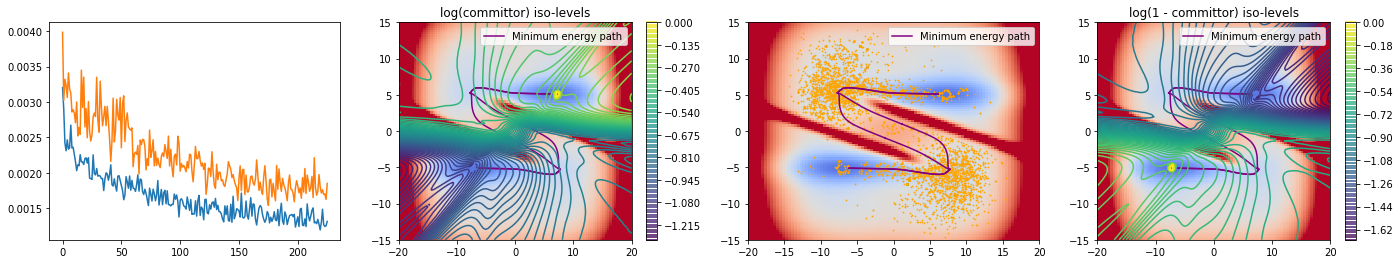

In [62]:
xi_on_grid = committor_training.committor_model.xi_forward(pot.x2d).reshape([100, 100])
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(24, 4)) 
# loss function evolution 
ax0.plot(loss_dict["train_loss"][:], label='train loss')
ax0.plot(loss_dict["test_loss"][:], label='test loss')
#ax0.legend()
# log committor plot 
pot.plot_potential_heat_map(ax1)
ax1.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax1.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax1.legend()

contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 100, cmap='viridis')
fig.colorbar(contour1, ax=ax1) 
ax1.set_title("log(committor) iso-levels")
# dataset distribution 
pot.plot_potential_heat_map(ax2)
ax2.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax2.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax2.scatter(committor_training.dataset["single_trajs_pos"][:,0, 0], committor_training.dataset["single_trajs_pos"][:,0,1], color='orange', s=0.5)
ax2.legend()

# log 1- committor plot  
pot.plot_potential_heat_map(ax3)
ax3.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax3.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1-xi_on_grid), 100, cmap='viridis')
fig.colorbar(contour3, ax=ax3) 
ax3.set_title("log(1 - committor) iso-levels")
ax3.legend()

Plot figures to compare to the finite element reference

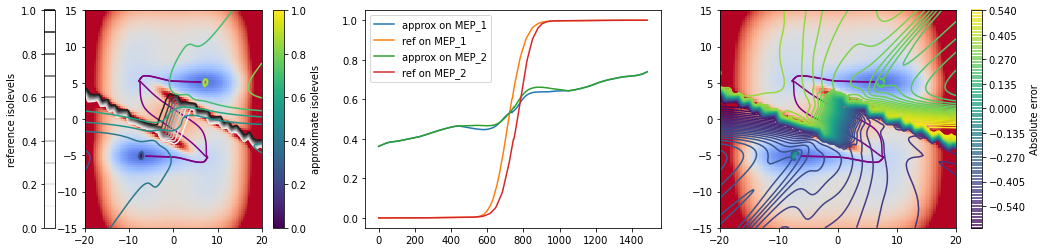

In [63]:
pts = np.loadtxt('ZP_pts.csv', delimiter=',', dtype=float)
tri = np.loadtxt('ZP_tri.csv', delimiter=',', dtype=int)
q = np.loadtxt('ZP_comm.txt', dtype=float)
from matplotlib.tri import Triangulation, TriFinder, LinearTriInterpolator
triangulation = Triangulation(pts[:,0], pts[:,1], tri)
interp = LinearTriInterpolator(triangulation, q, trifinder=triangulation.get_trifinder())

ref_committor_x2d = interp._interpolate_multikeys(x=pot.x2d[:,0], y=pot.x2d[:,1], tri_index=None, return_keys=('z',))[0].data.reshape(pot.n_bins_x, pot.n_bins_y)
committor_on_x2d = committor_training.committor_model.xi_forward(pot.x2d).reshape(pot.n_bins_x, pot.n_bins_y)

fig, (ax1, ax0, ax2) = plt.subplots(1, 3, figsize=(18, 4)) 
pot.plot_potential_heat_map(ax1)
ax1.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax1.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, ref_committor_x2d, np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]), cmap='Greys')
contour2 = committor_training.plot_committor_iso_levels(ax1, np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]), set_lim=False)
fig.colorbar(contour1, ax=ax1, label="reference isolevels", location="left") 
fig.colorbar(contour2, ax=ax1, label="approximate isolevels", location="right") 

pot.plot_potential_heat_map(ax2)
ax2.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
ax2.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
contour = ax2.contour(pot.x_plot, pot.y_plot, ref_committor_x2d - committor_on_x2d, 100, cmap='viridis')
fig.colorbar(contour, ax=ax2, label="Absolute error") 

ref_committor_MEP1 = interp._interpolate_multikeys(x=MEP_1[:, 0], y=MEP_1[:, 1], tri_index=None, return_keys=('z',))[0]
ref_committor_MEP2 = interp._interpolate_multikeys(x=MEP_2[:, 0], y=MEP_2[:, 1], tri_index=None, return_keys=('z',))[0]
committor_on_MEP1 = committor_training.committor_model.xi_forward(MEP_1)
committor_on_MEP2 = committor_training.committor_model.xi_forward(MEP_2)


ax0.plot(committor_on_MEP1, label="approx on MEP_1")
ax0.plot(ref_committor_MEP1, label="ref on MEP_1")
ax0.plot(committor_on_MEP2, label="approx on MEP_2")
ax0.plot(ref_committor_MEP2, label="ref on MEP_2")
ax0.legend()

Compute root mean squarred error of with respect to finite elements method solution on 1000 points sampled from the reactive trajectories density measure.  

In [64]:
react = np.loadtxt('react_trajs_ZP.txt')

ref_committor_react = interp._interpolate_multikeys(x=react[:,0], y=react[:,1], tri_index=None, return_keys=('z',))[0]
app_committor_react = committor_training.committor_model.xi_forward(react)[:, 0]
RMSE = np.sqrt(np.mean((ref_committor_react - app_committor_react)**2))
print("RMSE react = ", RMSE)


RMSE react =  0.4245186950597315


In [65]:
x = app_committor_react
y = app_committor_react_old
A = np.vstack([x, np.ones(len(x))]).T

coefs, r, _ ,_ = np.linalg.lstsq(A, y, rcond=None)
print("Regression score = ", r)

Regression score =  [0.56747404]


In [66]:
coefs

array([ 1.37937181, -0.27329215])

# Long run to obtain reactive trajectory density 

In [ ]:
n_conditions = 50
n_rep = 50
k_min = 1
AMS_on_ZP.set_threshold(1.0 * 10**(-16))
committor_training.committor_model.to('cuda:0')
AMS_on_ZP.set_xi(committor_training.committor_model.xi_forward)
ini_traj_f, ini_conds_f, _, n_steps_f = AMS_on_ZP.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
p_f, z_kills_f, replicas_f, total_md_steps_f = AMS_on_ZP.ams_run(ini_conds_f, n_rep, k_min, return_all=False, save_gauss=True)
AMS_on_ZP.set_forward(False)
AMS_on_ZP.set_xi(committor_training.committor_model.xi_backward)
ini_traj_b, ini_conds_b, _, n_steps_b = AMS_on_ZP.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
p_b, z_kills_b, replicas_b, total_md_steps_b = AMS_on_ZP.ams_run(ini_conds_b, n_rep, k_min, return_all=False, save_gauss=True)
AMS_on_ZP.set_forward(True)

In [ ]:
print(p_f)
print(p_b)

### New dataset with longer trajectories once a "decent" committor approx is available 

In [ ]:
N = 150 # time lagg in number of delta t
max_epochs = 10000

boudary_weight = 1.0 * 10**0
dataset = {"single_trajs_pos": [], 
           "single_trajs_gauss": [], 
           "single_trajs_weights": [], 
           'dt': dt, 'beta': beta}

i = 0
while i < len(ini_traj_f["x_traj"]) - N:
    x_traj = []
    gauss_traj = []
    while pot.in_P(ini_traj_f["x_traj"][i]) or pot.in_R(ini_traj_f["x_traj"][i]):
        i += 1
    x_traj.append(ini_traj_f["x_traj"][i:i+1])
    end_in_R_or_P = False
    n = 1
    if i < len(ini_traj_f["x_traj"]) - N:
        while n <= N:
            if not end_in_R_or_P:
                x_traj.append(ini_traj_f["x_traj"][n+i:n+i+1]) 
                gauss_traj.append(ini_traj_f["gauss_traj"][n+i:n+i+1])
            else:
                x_traj.append(x_end)
                gauss_traj.append(np.zeros_like(x_end))
            if pot.in_P(ini_traj_f["x_traj"][n+i]) or pot.in_R(ini_traj_f["x_traj"][n+i]):
                if not end_in_R_or_P:
                    n_max = n
                    x_end = ini_traj_f["x_traj"][n+i:n+i+1]
                end_in_R_or_P = True 
            n += 1
        if end_in_R_or_P:
            i += n_max + 1
        else: 
            i += N + 1
    else:
        i = len(ini_traj_f["x_traj"])
    dataset["single_trajs_pos"].append(x_traj)
    dataset["single_trajs_gauss"].append(gauss_traj)
    if end_in_R_or_P:
        dataset["single_trajs_weights"].append([boudary_weight])
    else:
        dataset["single_trajs_weights"].append([1.])
i = 0
while i < len(ini_traj_b["x_traj"]) - N:
    x_traj = []
    gauss_traj = []
    while pot.in_P(ini_traj_b["x_traj"][i]) or pot.in_R(ini_traj_b["x_traj"][i]):
        i += 1
    x_traj.append(ini_traj_b["x_traj"][i:i+1])
    end_in_R_or_P = False
    n = 1
    if i < len(ini_traj_b["x_traj"]) - N:
        while n <= N:
            if not end_in_R_or_P:
                x_traj.append(ini_traj_b["x_traj"][n+i:n+i+1]) 
                gauss_traj.append(ini_traj_b["gauss_traj"][n+i:n+i+1])
            else:
                x_traj.append(x_end)
                gauss_traj.append(np.zeros_like(x_end))
            if pot.in_P(ini_traj_b["x_traj"][n+i]) or pot.in_R(ini_traj_b["x_traj"][n+i]):
                if not end_in_R_or_P:
                    n_max = n
                    x_end = ini_traj_b["x_traj"][n+i:n+i+1]
                end_in_R_or_P = True 
            n += 1
        if end_in_R_or_P:
            i += n_max + 1
        else: 
            i += N + 1
    else:
        i = len(ini_traj_f["x_traj"])
    dataset["single_trajs_pos"].append(x_traj)
    dataset["single_trajs_gauss"].append(gauss_traj)
    if end_in_R_or_P:
        dataset["single_trajs_weights"].append([boudary_weight])
    else:
        dataset["single_trajs_weights"].append([1.])
dataset["single_trajs_weights"] = np.array(dataset["single_trajs_weights"])
dataset["single_trajs_gauss"] = np.array(dataset["single_trajs_gauss"])[:, :, 0, :]
dataset["single_trajs_pos"] = np.array(dataset["single_trajs_pos"])[:, :, 0, :]

In [ ]:
N = 150 # time lagg in number of delta t
max_epochs = 10000

boudary_weight = 1.0 * 10**0
dset = {"single_trajs_pos": [], 
        "single_trajs_gauss": [], 
        "single_trajs_weights": []}
for j in range(0, len(replicas_f)):
    i = 0
    while i < len(replicas_f[j]["x_traj"]) - N:
        x_traj = []
        gauss_traj = []
        while pot.in_P(replicas_f[j]["x_traj"][i]) or pot.in_R(replicas_f[j]["x_traj"][i]):
            i += 1
        x_traj.append(replicas_f[j]["x_traj"][i:i+1])
        end_in_R_or_P = False
        n = 1
        if i < len(replicas_f[j]["x_traj"]) - N:
            while n <= N:
                if not end_in_R_or_P:
                    x_traj.append(replicas_f[j]["x_traj"][n+i:n+i+1]) 
                    gauss_traj.append(replicas_f[j]["gauss_traj"][n+i:n+i+1])
                else:
                    x_traj.append(x_end)
                    gauss_traj.append(np.zeros_like(x_end))
                if pot.in_P(replicas_f[j]["x_traj"][n+i]) or pot.in_R(replicas_f[j]["x_traj"][n+i]):
                    if not end_in_R_or_P:
                        n_max = n
                        x_end = replicas_f[j]["x_traj"][n+i:n+i+1]
                    end_in_R_or_P = True 
                n += 1
            if end_in_R_or_P:
                i += n_max + 1
            else: 
                i += N + 1
        else:
            i = len(replicas_f[j]["x_traj"])
        dset["single_trajs_pos"].append(x_traj)
        dset["single_trajs_gauss"].append(gauss_traj)
        if end_in_R_or_P:
            dset["single_trajs_weights"].append([boudary_weight])
        else:
            dset["single_trajs_weights"].append([1.])
for j in range(0, len(replicas_b)):
    i = 0
    while i < len(replicas_b[j]["x_traj"]) - N:
        x_traj = []
        gauss_traj = []
        while pot.in_P(replicas_b[j]["x_traj"][i]) or pot.in_R(replicas_b[j]["x_traj"][i]):
            i += 1
        x_traj.append(replicas_b[j]["x_traj"][i:i+1])
        end_in_R_or_P = False
        n = 1
        if i < len(replicas_b[j]["x_traj"]) - N:
            while n <= N:
                if not end_in_R_or_P:
                    x_traj.append(replicas_b[j]["x_traj"][n+i:n+i+1]) 
                    gauss_traj.append(replicas_b[j]["gauss_traj"][n+i:n+i+1])
                else:
                    x_traj.append(x_end)
                    gauss_traj.append(np.zeros_like(x_end))
                if pot.in_P(replicas_b[j]["x_traj"][n+i]) or pot.in_R(replicas_b[j]["x_traj"][n+i]):
                    if not end_in_R_or_P:
                        n_max = n
                        x_end = replicas_b[j]["x_traj"][n+i:n+i+1]
                    end_in_R_or_P = True 
                n += 1
            if end_in_R_or_P:
                i += n_max + 1
            else: 
                i += N + 1
        else:
            i = len(replicas_b[j]["x_traj"])
        dset["single_trajs_pos"].append(x_traj)
        dset["single_trajs_gauss"].append(gauss_traj)
        if end_in_R_or_P:
            dset["single_trajs_weights"].append([boudary_weight])
        else:
            dset["single_trajs_weights"].append([1.])
dataset["single_trajs_weights"] = np.append(dataset["single_trajs_weights"], np.array(dset["single_trajs_weights"]), axis=0)
dataset["single_trajs_gauss"] = np.append(dataset["single_trajs_gauss"], np.array(dset["single_trajs_gauss"])[:, :, 0, :], axis=0)
dataset["single_trajs_pos"] = np.append(dataset["single_trajs_pos"], np.array(dset["single_trajs_pos"])[:, :, 0, :], axis=0)

In [ ]:
dataset["single_trajs_pos"].shape

### Box to gather all the structures within reactive trajectories.

In [211]:
react_trajs = replicas_b[-n_rep]["x_traj"]
for i in range(1, n_rep):
    react_trajs = np.append(react_trajs, replicas_b[-i]["x_traj"], axis=0)
for i in range(len(replicas_f)):
    react_trajs = np.append(react_trajs, replicas_f[-i]["x_traj"], axis=0)    
print(react_trajs.shape)

(8108162, 2)


(2000000, 2)


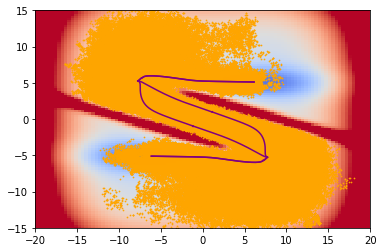

In [213]:
## Box to save a sub-sample of reactive trajectories sampled by AMS
size = 2 * 10**6

indices = np.random.choice(len(react_trajs), size=size)
react = react_trajs[indices][:, :2]

fig, (ax0) = plt.subplots(1, 1, figsize=(6, 4)) 
pot.plot_potential_heat_map(ax0)
ax0.plot(MEP_1[:, 0], MEP_1[:, 1], color='purple', label='Minimum energy path')
ax0.plot(MEP_2[:, 0], MEP_2[:, 1], color='purple')
ax0.scatter(react[:, 0], react[:, 1], color='orange', s=0.5)
print(react.shape)

#np.savetxt('react_trajs_ZP.txt', react)
np.savetxt('ZP_react_dens.txt', react)

In [206]:
interp_dir = y = pot.minP - pot.minR
def xi_interp_forward(x):
    return x.dot(interp_dir.T)
def xi_interp_backward(x):
    return -x.dot(interp_dir.T) 

In [207]:
def xi_x_forward(x):
    return x[:, 0]

def xi_x_backward(x):
    return 1 - x[:, 0]

In [208]:
def xi_comm_fem_forward(x):
    return interp._interpolate_multikeys(x=x[:,0], y=x[:,1], tri_index=None, return_keys=('z',))[0][0]

def xi_comm_fem_backward(x):
    return 1 - interp._interpolate_multikeys(x=x[:,0], y=x[:,1], tri_index=None, return_keys=('z',))[0][0]

In [209]:
m_real = 1
n_conditions = 200
n_rep = 200
k_min = 1

In [ ]:
AMS_on_MB.set_xi(xi_x_forward)
p_forward = []
for i in range(m_real):
    ini_traj_f, ini_conds_f, _, n_steps_f = AMS_on_ZP.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
    p_f, z_kills_f, replicas_f, total_md_steps_f = AMS_on_ZP.ams_run(ini_conds_f, n_rep, k_min, return_all=True, save_gauss=True)
    p_forward.append(p_f)
AMS_on_ZP.set_forward(False)
AMS_on_ZP.set_xi(xi_x_backward)
p_backward = []
for i in range(m_real):
    ini_traj_b, ini_conds_b, _, n_steps_b = AMS_on_ZP.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
    p_b, z_kills_b, replicas_b, total_md_steps_b = AMS_on_ZP.ams_run(ini_conds_b, n_rep, k_min, return_all=True, save_gauss=True)
    p_backward.append(p_b)
AMS_on_ZP.set_forward(True)

print("""with x""") 
print("""var forward : """, np.var(p_forward, ddof=1))
print("""mean forward : """, np.mean(p_forward))
print("""std forward : """, np.std(p_forward, ddof=1))
print("""var backward : """, np.var(p_backward, ddof=1))
print("""mean backward : """, np.mean(p_backward))
print("""std backward : """, np.std(p_backward, ddof=1))

In [ ]:
AMS_on_MB.set_xi(xi_interp_forward)
p_forward = []
for i in range(m_real):
    ini_traj_f, ini_conds_f, _, n_steps_f = AMS_on_ZP.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
    p_f, z_kills_f, replicas_f, total_md_steps_f = AMS_on_ZP.ams_run(ini_conds_f, n_rep, k_min, return_all=True, save_gauss=True)
    p_forward.append(p_f)
AMS_on_ZP.set_forward(False)
AMS_on_ZP.set_xi(xi_interp_backward)
p_backward = []
for i in range(m_real):
    ini_traj_b, ini_conds_b, _, n_steps_b = AMS_on_ZP.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
    p_b, z_kills_b, replicas_b, total_md_steps_b = AMS_on_ZP.ams_run(ini_conds_b, n_rep, k_min, return_all=True, save_gauss=True)
    p_backward.append(p_b)
AMS_on_ZP.set_forward(True)

print("""with interp""") 
print("""var forward : """, np.var(p_forward, ddof=1))
print("""mean forward : """, np.mean(p_forward))
print("""std forward : """, np.std(p_forward, ddof=1))
print("""var backward : """, np.var(p_backward, ddof=1))
print("""mean backward : """, np.mean(p_backward))
print("""std backward : """, np.std(p_backward, ddof=1))

In [ ]:
AMS_on_ZP.set_xi(committor_training.committor_model.xi_forward)
p_forward = []
for i in range(m_real):
    ini_traj_f, ini_conds_f, _, n_steps_f = AMS_on_ZP.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
    p_f, z_kills_f, replicas_f, total_md_steps_f = AMS_on_ZP.ams_run(ini_conds_f, n_rep, k_min, return_all=True, save_gauss=True)
    p_forward.append(p_f)
AMS_on_ZP.set_forward(False)
AMS_on_ZP.set_xi(committor_training.committor_model.xi_backward)
p_backward = []
for i in range(m_real):
    ini_traj_b, ini_conds_b, _, n_steps_b = AMS_on_ZP.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
    p_b, z_kills_b, replicas_b, total_md_steps_b = AMS_on_ZP.ams_run(ini_conds_b, n_rep, k_min, return_all=True, save_gauss=True)
    p_backward.append(p_b)
AMS_on_ZP.set_forward(True)

print("""with approx committor""") 
print("""var forward : """, np.var(p_forward, ddof=1))
print("""mean forward : """, np.mean(p_forward))
print("""std forward : """, np.std(p_forward, ddof=1))
print("""var backward : """, np.var(p_backward, ddof=1))
print("""mean backward : """, np.mean(p_backward))
print("""std backward : """, np.std(p_backward, ddof=1))

In [210]:
m_real = 1
n_conditions = 100
n_rep = 100
k_min = 1
AMS_on_ZP.set_xi(xi_comm_fem_forward)
AMS_on_ZP.set_threshold(1.0 * 10**(-8))
p_forward = []
for i in range(m_real):
    ini_traj_f, ini_conds_f, _, n_steps_f = AMS_on_ZP.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
    p_f, z_kills_f, replicas_f, total_md_steps_f = AMS_on_ZP.ams_run(ini_conds_f, n_rep, k_min, return_all=True, save_gauss=True)
    p_forward.append(p_f)
AMS_on_ZP.set_forward(False)
AMS_on_ZP.set_xi(xi_comm_fem_backward)
p_backward = []
for i in range(m_real):
    ini_traj_b, ini_conds_b, _, n_steps_b = AMS_on_ZP.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
    p_b, z_kills_b, replicas_b, total_md_steps_b = AMS_on_ZP.ams_run(ini_conds_b, n_rep, k_min, return_all=True, save_gauss=True)
    p_backward.append(p_b)
AMS_on_ZP.set_forward(True)


print("""with fem committor""") 
print("""var forward : """, np.var(p_forward, ddof=1))
print("""mean forward : """, np.mean(p_forward))
print("""std forward : """, np.std(p_forward, ddof=1))
print("""var backward : """, np.var(p_backward, ddof=1))
print("""mean backward : """, np.mean(p_backward))
print("""std backward : """, np.std(p_backward, ddof=1))

with fem committor
var forward :  nan
mean forward :  5.468266988182576e-07
std forward :  nan
var backward :  nan
mean backward :  1.4802763671281627e-07
std backward :  nan


/home/tpigeon/miniconda3/envs/env_ae/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/tpigeon/miniconda3/envs/env_ae/lib/python3.10/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tpigeon/miniconda3/envs/env_ae/lib/python3.10/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [ ]:
torch.save(committor_training.committor_model, "AMS_xi_comm_ZP")